### Import Statements

In [1]:
import requests
import fitz  # PyMuPDF
import re

In [2]:
!pip install -q -U immutabledict sentencepiece
!git clone https://github.com/google/gemma_pytorch.git

fatal: destination path 'gemma_pytorch' already exists and is not an empty directory.


### Data Retriaval
Download of the pdf file(s)

In [2]:
pdf_url = "https://bugs.python.org/file47781/Tutorial_EDIT.pdf"

def download_pdf(url):
    response = requests.get(url)
    with open('temp.pdf', 'wb') as f:
        f.write(response.content)
    return 'temp.pdf'

def pdf_to_text(filename):
    doc = fitz.open(filename)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def clean_text(text):
    # Remove double spaces
    return re.sub(' +', ' ', text)

def split_text_into_chunks(text, num_chunks):
    words = text.split()
    chunk_size = len(words) // num_chunks
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

pdf_file = download_pdf(pdf_url)
pdf_text = pdf_to_text(pdf_file)
clean_pdf_text = clean_text(pdf_text)

# Decide on the number of chunks you want
num_chunks = 200
chunks = split_text_into_chunks(clean_pdf_text, num_chunks)

# This will print the chunks, you can process them further as needed
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}: {chunk[:100]}...")  # Printing the first 100 characters of each chunk for brevity


Chunk 1: Python Tutorial Release 3.7.0 Guido van Rossum and the Python development team September 02, 2018 Py...
Chunk 2: 19 4.2 for Statements . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 3: . 24 4.8 Intermezzo: Coding Style . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 4: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 38 5.6 Looping Techniques . . ...
Chunk 5: . . . 46 6.3 The dir() Function . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 6: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 61 8.3 Handling Exceptions ....
Chunk 7: 69 9.1 A Word About Names and Objects . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 8: . . . . . . . . . . . . 78 9.7 Odds and Ends . . . . . . . . . . . . . . . . . . . . . . . . . . . ....
Chunk 9: File Wildcards . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Data Cleaning
Using the 7B instruct model

In [3]:
from gemma_pytorch.gemma.config import get_config_for_7b
from gemma_pytorch.gemma.model import GemmaForCausalLM
import contextlib
import os
import torch

from IPython.display import Markdown as md

In [4]:
VARIANT = "7b-it-quant" 
MACHINE_TYPE = "mps" 
weights_dir = 'archive/'

In [5]:
@contextlib.contextmanager
def _set_default_tensor_type(dtype: torch.dtype):
    """Sets the default torch dtype to the given dtype."""
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

In [7]:
# Model Config.
model_config = get_config_for_7b()
model_config.tokenizer = os.path.join(weights_dir, "tokenizer.model")
model_config.quant = "quant" in VARIANT

In [8]:
device = torch.device(MACHINE_TYPE)
with _set_default_tensor_type(model_config.get_dtype()):
    model = GemmaForCausalLM(model_config)
    ckpt_path = os.path.join(weights_dir, f'gemma-{VARIANT}.ckpt')
    model.load_weights(ckpt_path)
    model = model.to(device).eval()

In [ ]:
USER_CHAT_TEMPLATE = "<start_of_turn>user\n{prompt}<end_of_turn>\n"
MODEL_CHAT_TEMPLATE = "<start_of_turn>model\n{prompt}<end_of_turn>\n"

USER_PROMPT = "How to join a competition on the Kaggle platform?"

prompt = (
    USER_CHAT_TEMPLATE.format(prompt=USER_PROMPT)
    + MODEL_CHAT_TEMPLATE.format(prompt="Kaggle Platform.")
    + "<start_of_turn>model\n"
)

result = model.generate(
    USER_CHAT_TEMPLATE.format(prompt=prompt),
    device=device,
    output_len=1000,
)

In [4]:
from mlx_lm import load, generate

model, tokenizer = load("mlx-community/quantized-gemma-7b-it")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Calculate the differences between original and cleaned lengths
differences = []
new_data = []
for chunk in tqdm(chunks, desc="Calculating differences"):
    prompt = f"<start_of_turn>user Clean the following data so that only relevant content remains and unneccessary signs are removed. Do not make stuff up on your own: {chunk} <start_of_turn>model Sure, here is the cleaned data:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    differences.append(len(response) / len(chunk))
    new_data.append(response)

Calculating differences: 100%|██████████| 201/201 [19:18<00:00,  5.76s/it]


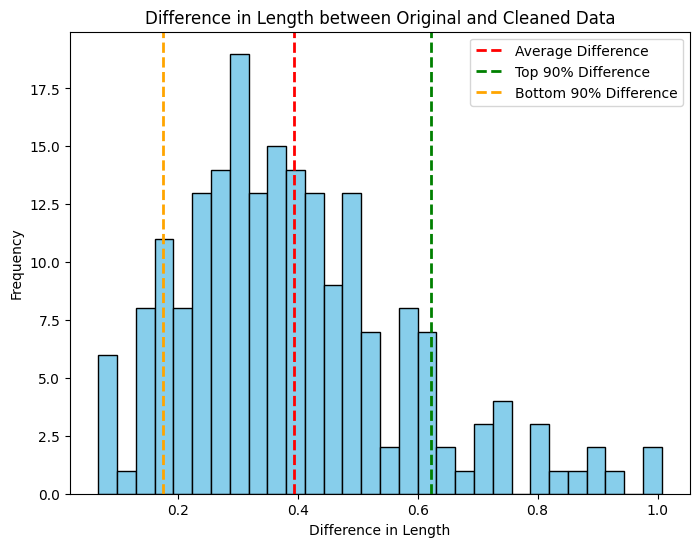

In [6]:
# Calculate the average difference
average_difference = np.mean(differences)

# Calculate the top and bottom 90% differences
top_90_percentile = np.percentile(differences, 90)
bottom_90_percentile = np.percentile(differences, 10)

# Plot the differences
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=30, color='skyblue', edgecolor='black')
plt.axvline(average_difference, color='red', linestyle='dashed', linewidth=2, label='Average Difference')
plt.axvline(top_90_percentile, color='green', linestyle='dashed', linewidth=2, label='Top 90% Difference')
plt.axvline(bottom_90_percentile, color='orange', linestyle='dashed', linewidth=2, label='Bottom 90% Difference')
plt.xlabel('Difference in Length')
plt.ylabel('Frequency')
plt.title('Difference in Length between Original and Cleaned Data')
plt.legend()
plt.show()

In [7]:
import re
new_text = "\n".join(new_data)
chunks = split_text_into_chunks(new_text, int(num_chunks / 2))
# chunks = split_text_into_chunks(new_text, 5)

chapter_text = []
for chunk in tqdm(chunks, desc="Seperating into senseful chunks"):
    prompt = f"<start_of_turn>user Add /chapter at every headline, where a new chapter begins: {chunk} <start_of_turn>model Sure, here is the seperated text:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    chapter_text.append(response)

Seperating into senseful chunks: 100%|██████████| 101/101 [13:36<00:00,  8.08s/it]


In [8]:
new_text = "\n".join(chapter_text)
# Split the text 2 indices before every mention of "chapter" into a list of strings
split_text = re.split(r"(?<=\bChapter\b)", new_text)

# Remove leading and trailing whitespaces from each string
split_text = [text.strip() for text in split_text]

### Embedding Function
for ChromaDB

### Data Loading
Loading the data into ChromaDB

In [9]:
import chromadb
from chromadb.utils import embedding_functions # This helps us fetch our embedding model

embedding_model = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="thenlper/gte-large")
client = chromadb.PersistentClient(path="./chromadb")

ids = [f"Tutorial_{i}" for i in range(len(split_text))]
metadata = [{"id": f"Tutorial_{i}"} for i in range(len(split_text))]

collection_exists = "Green-AI" in [collection.name for collection in client.list_collections()]
if not collection_exists:
    collection = client.create_collection(
        name=f"Green-AI",
        metadata={"hnsw:space": "cosine"}, # l2 is the default
        embedding_function=embedding_model,
    )
    collection.add(
        documents=split_text,
        metadatas=metadata,
        ids=ids,
    )

### Benchmarking
Benchmarking the retrieval process by automatically generating specific questions for each chunk and testing, whether the right document is retrieved.

In [134]:
data = collection.get()
questions = []
for id, document in tqdm(zip(data["ids"], data["documents"]), desc="Generating questions"):
    prompt = f"<start_of_turn>user Create a specific question for this text: {document} <start_of_turn>model Sure, here is the question:"
    question = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
    question = question.replace("\n", "")
    question = question.replace("*", "")
    questions.append(question)

Generating questions: 125it [02:36,  1.25s/it]


In [140]:
import random
random_questions = random.sample(questions, 5)
for question in random_questions:
    print(question)

How does the "File" and "Method" concepts in Python differ from the "Open built-in function" and how do they relate to each other?
How does the text describe the use of lists as queues and the recommended solution for implementing a queue in Python?
How does the concept of a virtual environment and a virtual machine relate to the Zen of Python principles?
How does Python's high-level data types allow you to express complex operations in a single statement?
Explain the key differences between tuples and lists in Python, as described in the text.


In [156]:
accuracies = {}
lengths = [1, 2, 3, 4, 5]
for n_results in lengths:
    datapoints = []
    for id, question in zip(data["ids"], questions):
        results = collection.query(query_texts=question, n_results=n_results)
        result_ids = results["ids"][0]
        if id in result_ids:
            datapoints.append(1)
        else:
            datapoints.append(0)

    accuracies[n_results] = sum(datapoints) / len(datapoints)
accuracies

{1: 0.824, 2: 0.896, 3: 0.928, 4: 0.944, 5: 0.944}

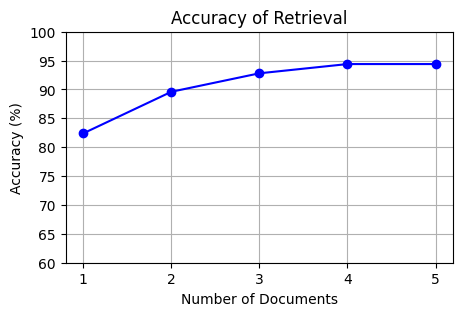

In [158]:
x = list(accuracies.keys())
y = [value * 100 for value in list(accuracies.values())]

plt.figure(figsize=(5, 3))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Retrieval')
plt.xlabel('Number of Documents')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)  # Set y-axis limits to show percentages clearly
plt.grid(True)
plt.xticks(x)  # Ensure all x-axis values are shown
plt.show()

### RAG Class
Document retrieval and prompt engineering

In [129]:
class RAG:

    def __init__(self, model, tokenizer, collection) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.collection = collection

    def query(self, prompt, n_results=1):
        return self.collection.query(query_texts=prompt, n_results=n_results)
    
    def generate_text(self, prompt: str) -> str:
        result = self.collection.query(
            query_texts=prompt,
            n_results=3,
        )
        documents = ' '.join(result["documents"][0])
        prompt = f"<start_of_turn>user You are an assistant. Answer the following question based on the following knowledge base. Knowledge Base: {documents}\n Question: {prompt} <start_of_turn>model "
        output = generate(self.model, self.tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
        return output

### LLM Generating Answers
Including a Chat Interface

In [106]:
rag = RAG(model, tokenizer, collection)
print(rag.generate_text("How do I use String Pattern Matching in Python?"))
print("\n\n\n New Document \n\n\n")
print(rag.generate_text_naive("How do I use String Pattern Matching in Python?"))



The text provided does not describe how to use String Pattern Matching in Python, therefore I cannot answer the question.



 New Document 





The text does not mention String Pattern Matching in Python, therefore I cannot answer this question.
